In [24]:
import torch
import torch.nn as nn
from torch.autograd import Variable as V
from lib.Exercise1_1 import LQRSolver
from torch.utils.data import TensorDataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import time 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Proj_dtype = torch.double
Proj_device = 'cpu' 
class DGMNN(nn.Module):
    def __init__(self):
        super(DGMNN, self).__init__()
        self.layer1 = nn.Linear(3, 100)  
        self.layer2 = nn.Linear(100, 100)
        self.layer3 = nn.Linear(100, 100)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.output = nn.Linear(100, 1)
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.tanh(self.layer2(x))
        x = self.relu(self.layer3(x))

        return self.output(x)



In [25]:
class DGMNN2(nn.Module):
    def __init__(self):
        super(DGMNN2, self).__init__()
        self.layer1 = nn.Linear(3, 100)
        self.layer2 = nn.Linear(100, 100)
        self.layer3 = nn.Linear(100, 100)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.output = nn.Linear(100, 1)
        
    def forward(self, x):

        out1 = self.relu(self.layer1(x))
        identity = out1
        out2 = self.tanh(self.layer2(out1)+identity)
        identity = out2
        out3 = self.relu(self.layer3(out2)+identity)
        return self.output(out3)


In [26]:
def get_hessian(grad,x):
    Hessian = torch.tensor([], device = Proj_device)
    
    for i in range(len(x)):
        hessian = torch.tensor([], device = Proj_device)
        for j in range(len(grad[i])):
            u_xxi = torch.autograd.grad(grad[i][j], x, grad_outputs=torch.ones_like(grad[i][j]), retain_graph=True,create_graph=True, allow_unused=True)[0]           
            hessian = torch.cat((hessian, u_xxi[i].unsqueeze(0)))
        Hessian = torch.cat((Hessian, hessian.unsqueeze(0)),dim = 0)
        #print(Hessian)
    return Hessian

def get_hessian_(model,t,x):
    Hessian = torch.tensor([], device = Proj_device)
    for i in range(len(t)):
        x_i = V(x[i],requires_grad=True)
        input = torch.cat(((t[i]).unsqueeze(0), x_i),dim=0)
        u_in = model(input)
        grad = torch.autograd.grad(u_in, x_i, grad_outputs=torch.ones_like(u_in), create_graph=True, retain_graph=True)[0]
        hessian = torch.tensor([], device = Proj_device)
        for j in range(len(grad)):
            u_xxi = torch.autograd.grad(grad[j], x_i, grad_outputs=torch.ones_like(grad[j]), retain_graph=True,create_graph=True, allow_unused=True)[0]           
            hessian = torch.cat((hessian, u_xxi.unsqueeze(0)))
        Hessian = torch.cat((Hessian, hessian.unsqueeze(0)),dim = 0)
    return Hessian

def pde_residual(model, t, x):
    
    input = torch.cat((t.unsqueeze(1), x),dim=1)
    
    u = model(input)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]

    u_xx = get_hessian(u_x,x)

#    u_xx = get_hessian_(model,t,x)
 
    residual = u_t + 0.5 * torch.einsum('bii->b', sigma @ sigma.transpose(1,2) @ u_xx) + (u_x.unsqueeze(1) @ (H @ x.unsqueeze(1).transpose(1,2)) + u_x.unsqueeze(1) @ M @ alpha + x.unsqueeze(1) @ C @ x.unsqueeze(1).transpose(1,2) + alpha.transpose(1,2) @ D @ alpha).squeeze()
    return residual

def boundary_condition(model,t, x):

    
    T_input = T * torch.ones_like(t)

    input = torch.cat((T_input.unsqueeze(1), x),dim=1)
    u = model(input)

    return u - (x.unsqueeze(1) @ R @ x.unsqueeze(1).transpose(1,2)).squeeze()

def total_residual(model, t, x):
    
    residual_loss = pde_residual(model, t, x).pow(2).mean()
    boundary_loss = boundary_condition(model,t,x).pow(2).mean()
    
    return residual_loss + boundary_loss


In [27]:
def new_data(num_samples):
    #num_samples = 10000
    t_samples = T * torch.rand(num_samples, dtype=Proj_dtype, device = Proj_device, requires_grad=True)
    x_ends = torch.tensor([-3,3], dtype = Proj_dtype)
    x_samples = x_ends[0] + (x_ends[1]- x_ends[0]) * torch.rand(num_samples , 2, dtype=Proj_dtype, device = Proj_device, requires_grad=True)
    return t_samples,x_samples

In [28]:
# Define matrices for LQR problem

H = torch.tensor([[1.2, 0.8], [-0.6, 0.9]], dtype=Proj_dtype, device = Proj_device)
M = torch.tensor([[0.5,0.7], [0.3,1.0]], dtype=Proj_dtype, device = Proj_device)
sigma = torch.tensor([[[0.08],[0.11]]], dtype=Proj_dtype, device = Proj_device)
alpha = torch.tensor([[[1],[1]]], dtype=Proj_dtype, device = Proj_device)
C = torch.tensor([[1.6, 0.0], [0.0, 1.1]], dtype=Proj_dtype, device = Proj_device)
D = torch.tensor([[0.5, 0.0], [0.0, 0.7]], dtype=Proj_dtype, device = Proj_device)
R = torch.tensor([[0.9, 0.0], [0.0, 1.0]], dtype=Proj_dtype, device = Proj_device)
T = torch.tensor(1.0, dtype=Proj_dtype, device = Proj_device)

solver = LQRSolver(H, M, sigma, C, D, R, T=T, method="euler")


In [59]:
samplesize = [100,1000,5000]
epochs = 40
Batch_size = 5
for sz in samplesize:


    model_DGM = DGMNN2().double()
    # stat_dict = torch.load('model2_DGM_state_dict.pt', map_location=torch.device('cpu'))
    # model_DGM.load_state_dict(stat_dict)
    #model_DGM = DGMNN().float().to(Proj_device)
    # Prepare for training
    optimizer_DGM = torch.optim.Adam(model_DGM.parameters(), lr=0.01)
    scheduler_DGM = lr_scheduler.ExponentialLR(optimizer_DGM, gamma=0.9)


    epoch_losses = []
    # 新建文本文件,f'epochloss{%d}'sz
    # 新建文本文件用于存储epoch的损失
    loss_filename = f'Exercise3/epoch_loss_{sz}.txt'
    with open(loss_filename, 'w') as file:
        file.write('Epoch,Loss\n')

    Batch_size = 5
    epochs = 40

    for batch in range(Batch_size):
    
        print(f'Batch {batch+1}/{Batch_size}'+'\n')
        
        t_data,x_data = new_data(sz)
        dataset = TensorDataset(t_data,x_data)
        dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

        for epoch in range(epochs):

            model_DGM.train()
            total_loss = 0
            
            for batch_idx, (t_data_,x_data_) in enumerate(dataloader):
                optimizer_DGM.zero_grad()
                t_v = V(t_data_,requires_grad=True)
                x_v = V(x_data_,requires_grad=True)
                loss = total_residual(model_DGM, t_v, x_v) 
                loss.backward(retain_graph=False)
                #loss.backward(retain_graph=True)
                optimizer_DGM.step()
                total_loss += loss.item()
            epoch_losses.append(total_loss / len(dataloader))
            
            scheduler_DGM.step()
            if epoch == 0:
                print(f'Epoch {epoch+1}/{epochs} \t Loss: {total_loss / len(dataloader)}')
            if(epoch+1)% 10 == 0:
                torch.save(model_DGM.state_dict(), f'Exercise3/model2_DGM_state_dict_{sz}.pt')
            if (epoch+1) % 5 == 0:
                print(f'Epoch {epoch+1}/{epochs} \t Loss: {total_loss / len(dataloader)}')

        print('\n')
        # sdhsl
        # 在每个批次结束后，以追加模式将epoch损失数据添加到文件
        with open(loss_filename, 'a') as file:
            for i, loss in enumerate(epoch_losses, 1):
                file.write(f'{i},{loss}\n')
    model_DGM.eval()

Batch 1/5

Epoch 1/40 	 Loss: 174.24934116613008
Epoch 5/40 	 Loss: 97.97454517718143
Epoch 10/40 	 Loss: 55.016093488863355
Epoch 15/40 	 Loss: 44.624411598407896
Epoch 20/40 	 Loss: 40.44729662718819
Epoch 25/40 	 Loss: 37.21147079524681
Epoch 30/40 	 Loss: 35.192210828578276
Epoch 35/40 	 Loss: 35.00448991881793
Epoch 40/40 	 Loss: 34.13497905158484


Batch 2/5

Epoch 1/40 	 Loss: 39.062453028968086
Epoch 5/40 	 Loss: 38.752469045172106
Epoch 10/40 	 Loss: 38.66329961379862
Epoch 15/40 	 Loss: 37.98371851579328
Epoch 20/40 	 Loss: 37.8250581563581
Epoch 25/40 	 Loss: 37.772765427889695
Epoch 30/40 	 Loss: 37.692621985353185
Epoch 35/40 	 Loss: 37.63902876588739
Epoch 40/40 	 Loss: 37.61164468334105


Batch 3/5

Epoch 1/40 	 Loss: 35.381719265333956
Epoch 5/40 	 Loss: 35.37164228146875
Epoch 10/40 	 Loss: 35.3980981062671
Epoch 15/40 	 Loss: 35.39135663571085
Epoch 20/40 	 Loss: 35.387178886355905
Epoch 25/40 	 Loss: 35.384665849798154
Epoch 30/40 	 Loss: 35.38317521620577
Epoch 35/4

In [43]:
# Function to load data from a txt file
def load_data_from_txt(file_path):
    # Read the .txt file into a DataFrame
    df = pd.read_csv(file_path)
    return df

# Example usage
file_path_100 = 'Exercise3/epoch_loss_100.txt'  # Update this path to your actual file location
file_path_1000 = 'Exercise3/epoch_loss_1000.txt'  # Update this path
file_path_5000 = 'Exercise3/epoch_loss_5000.txt'  # Update this path

df_100 = load_data_from_txt(file_path_100)
print(df_100)
df_1000 = load_data_from_txt(file_path_1000)
df_5000 = load_data_from_txt(file_path_5000)


     Epoch        Loss
0        1  174.249341
1        2  150.807328
2        3  132.610211
3        4  114.849114
4        5   97.974545
..     ...         ...
595    196   31.733956
596    197   31.733956
597    198   31.733956
598    199   31.733956
599    200   31.733956

[600 rows x 2 columns]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0      174.249341
1      150.807328
2      132.610211
3      114.849114
4       97.974545
          ...    
595     31.733956
596     31.733956
597     31.733956
598     31.733956
599     31.733956
Name: Loss, Length: 600, dtype: float64


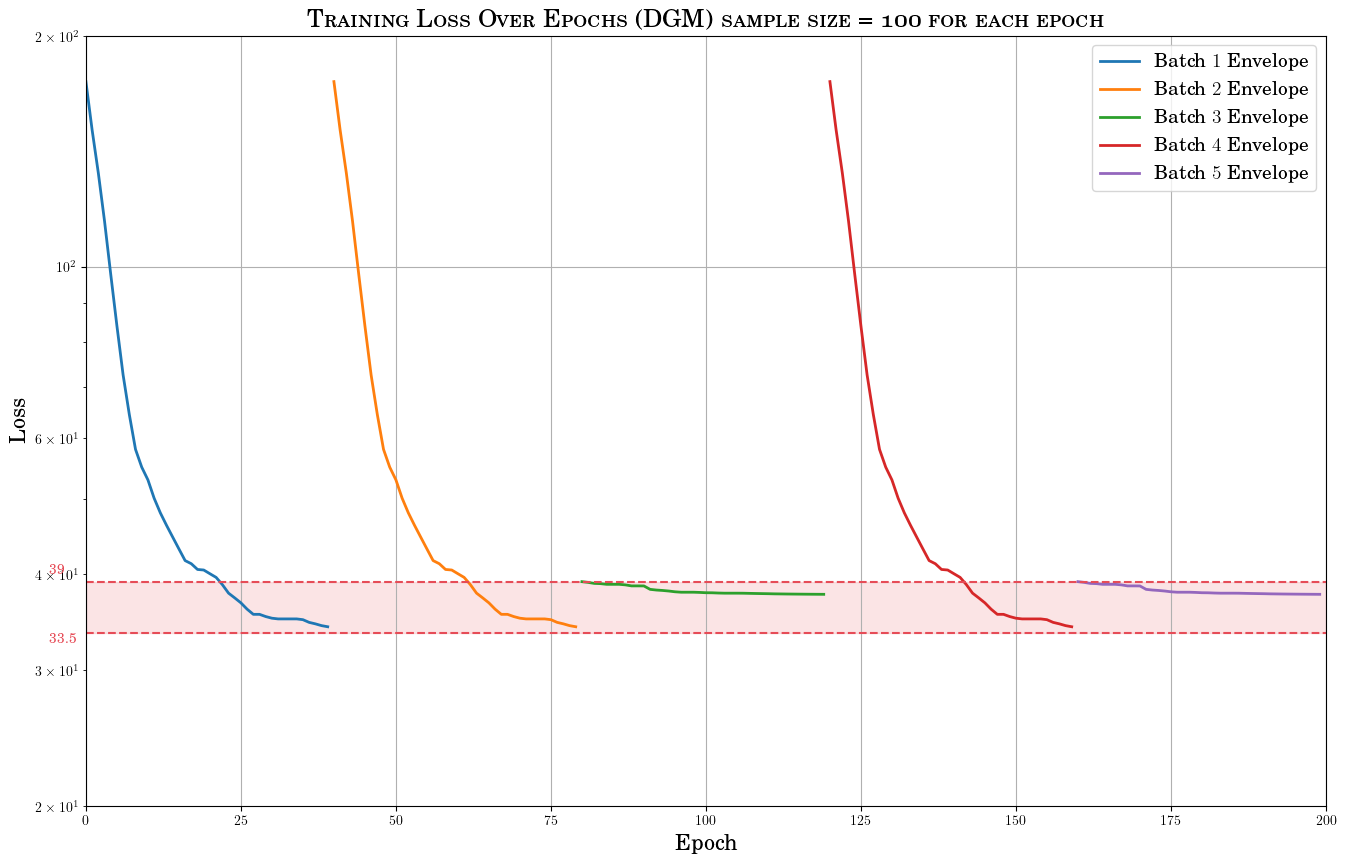

In [93]:
# Plotting the training loss with adjusted y-axis limits
batch_size = 5
epoch = 40
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{tgschola}')

# Convert epoch_losses to a numeric type if it's not already
epoch_losses = pd.to_numeric(df_100['Loss'], errors='coerce')
print(epoch_losses)
envelope_lower = np.minimum.accumulate(epoch_losses)
#print(envelope_lower)
plt.figure(figsize=(16, 10))

epoch_list = range(batch_size*epochs)
for i in range(batch_size):
    start = i * epochs
    end = (i + 1) * epochs
    batch_epochs = epoch_list[start:end]
    batch_losses = epoch_losses[start:end]
    
    envelope_lower = np.minimum.accumulate(batch_losses)
    
    plt.plot(batch_epochs, envelope_lower, label=r'\rmfamily \textmd {Batch }'+f'${i+1}$' r'\textmd{ Envelope}',lw=2)
x = np.linspace(0,200)
plt.axhline(y=33.5, xmin=0, xmax=200, color=(230/255, 76/255, 87/255), linestyle='--')
plt.axhline(y=39, xmin=0, xmax=200, color=(230/255, 76/255, 87/255), linestyle='--')
plt.fill_between(x, 33.5, 39, where=(x >= -20) & (x <= 220),color=(230/255, 76/255, 87/255, 0.15), interpolate=True)

plt.yscale('log')
plt.xlabel(r'\rmfamily \textmd {Epoch}', fontsize=16)
plt.ylabel(r'\rmfamily \textmd {Loss}', fontsize=16)
plt.title(r'\rmfamily {\textsc{Training Loss Over Epochs (DGM) sample size = 100 for each epoch}}', fontsize=18)
plt.xlim(0,200)
plt.ylim(2e1, 2e2)  # Setting the y-axis limit to better visualize the decrease in loss
plt.text(-6, 40, r'\rmfamily \textmd {39}', color=(230/255, 76/255, 87/255), fontsize=10)
plt.text(-6, 32.5, r'\rmfamily \textmd {33.5}', color=(230/255, 76/255, 87/255), fontsize=10)
plt.legend(fontsize=14)
plt.grid(True)  # Add grid for better readability

plt.savefig('Exercise3/Training Loss_100 (DGM).eps', format='eps', dpi=600)
plt.savefig('Exercise3/Training Loss_100 (DGM).png', format='png', dpi=600)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0      140.258046
1       98.289556
2       70.091455
3       52.331147
4       41.707283
          ...    
595     23.908115
596     23.858974
597     23.914452
598     23.930575
599     23.882599
Name: Loss, Length: 600, dtype: float64


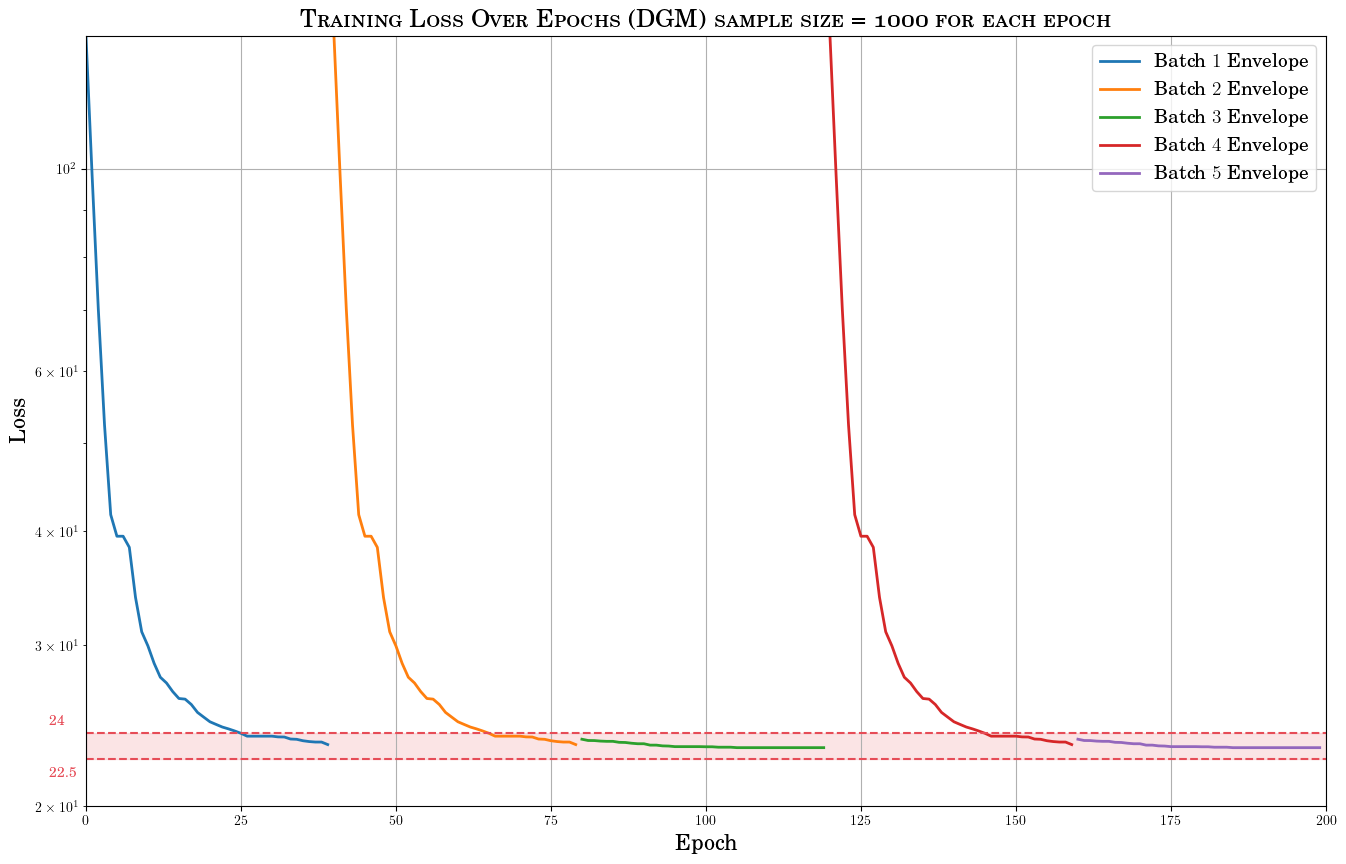

In [100]:
# Plotting the training loss with adjusted y-axis limits
batch_size = 5
epoch = 40
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{tgschola}')

# Convert epoch_losses to a numeric type if it's not already
epoch_losses = pd.to_numeric(df_1000['Loss'], errors='coerce')
print(epoch_losses)
envelope_lower = np.minimum.accumulate(epoch_losses)
#print(envelope_lower)
plt.figure(figsize=(16, 10))

epoch_list = range(batch_size*epochs)
for i in range(batch_size):
    start = i * epochs
    end = (i + 1) * epochs
    batch_epochs = epoch_list[start:end]
    batch_losses = epoch_losses[start:end]
    
    envelope_lower = np.minimum.accumulate(batch_losses)
    
    plt.plot(batch_epochs, envelope_lower, label=r'\rmfamily \textmd {Batch }'+f'${i+1}$' r'\textmd{ Envelope}',lw=2)
x = np.linspace(0,200)
plt.axhline(y=22.5, xmin=0, xmax=200, color=(230/255, 76/255, 87/255), linestyle='--')
plt.axhline(y=24, xmin=0, xmax=200, color=(230/255, 76/255, 87/255), linestyle='--')
plt.fill_between(x, 22.5, 24, where=(x >= 0) & (x <= 220),color=(230/255, 76/255, 87/255, 0.15), interpolate=True)

plt.yscale('log')
plt.xlabel(r'\rmfamily \textmd {Epoch}', fontsize=16)
plt.ylabel(r'\rmfamily \textmd {Loss}', fontsize=16)
plt.title(r'\rmfamily {\textsc{Training Loss Over Epochs (DGM) sample size = 1000 for each epoch}}', fontsize=18)
plt.xlim(0,200)
plt.ylim(2e1, 1.4e2)  # Setting the y-axis limit to better visualize the decrease in loss
plt.text(-6, 24.5, r'\rmfamily \textmd {24}', color=(230/255, 76/255, 87/255), fontsize=10)
plt.text(-6, 21.5, r'\rmfamily \textmd {22.5}', color=(230/255, 76/255, 87/255), fontsize=10)
plt.legend(fontsize=14)
plt.grid(True)  # Add grid for better readability

plt.savefig('Exercise3/Training Loss_1000 (DGM).eps', format='eps', dpi=600)
plt.savefig('Exercise3/Training Loss_1000 (DGM).png', format='png', dpi=600)

plt.show()

0      82.281870
1      31.952974
2      22.914137
3      19.289235
4      17.406257
         ...    
595    14.134692
596    14.142847
597    14.141897
598    14.151494
599    14.178374
Name: Loss, Length: 600, dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


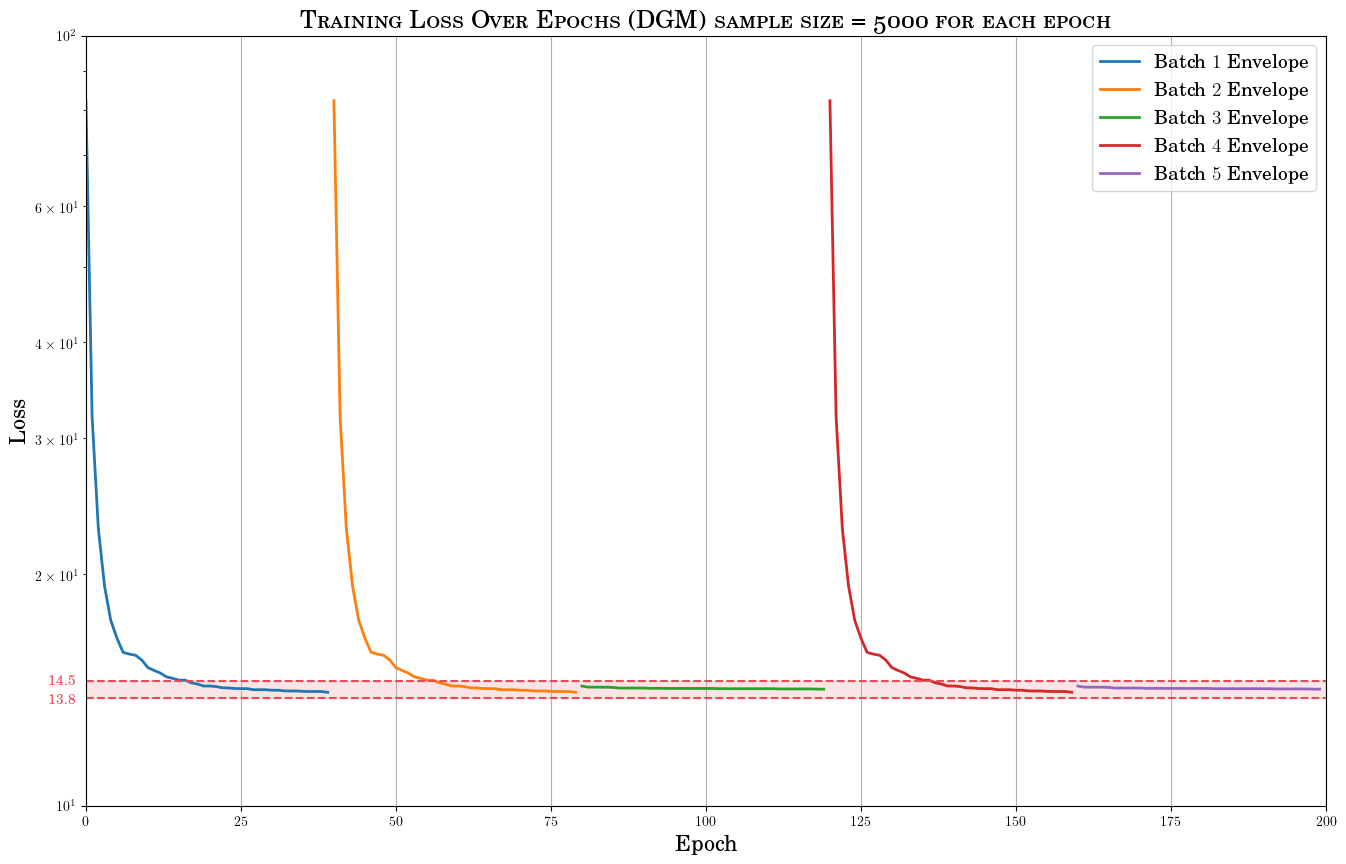

In [85]:
# Plotting the training loss with adjusted y-axis limits
batch_size = 5
epoch = 40
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{tgschola}')

# Convert epoch_losses to a numeric type if it's not already
epoch_losses = pd.to_numeric(df_5000['Loss'], errors='coerce')
print(epoch_losses)
envelope_lower = np.minimum.accumulate(epoch_losses)
#print(envelope_lower)
plt.figure(figsize=(16, 10))

epoch_list = range(batch_size*epochs)
for i in range(batch_size):
    start = i * epochs
    end = (i + 1) * epochs
    batch_epochs = epoch_list[start:end]
    batch_losses = epoch_losses[start:end]
    
    envelope_lower = np.minimum.accumulate(batch_losses)
    
    plt.plot(batch_epochs, envelope_lower, label=r'\rmfamily \textmd {Batch }'+f'${i+1}$' r'\textmd{ Envelope}',lw=2)
x = np.linspace(0,200)
plt.axhline(y=13.8, xmin=0, xmax=200, color=(230/255, 76/255, 87/255), linestyle='--')
plt.axhline(y=14.5, xmin=0, xmax=200, color=(230/255, 76/255, 87/255), linestyle='--')
plt.fill_between(x, 13.8, 14.5, where=(x >= -20) & (x <= 220),color=(230/255, 76/255, 87/255, 0.15), interpolate=True)

plt.yscale('log')
plt.xlabel(r'\rmfamily \textmd {Epoch}', fontsize=16)
plt.ylabel(r'\rmfamily \textmd {Loss}', fontsize=16)
plt.title(r'\rmfamily {\textsc{Training Loss Over Epochs (DGM) sample size = 5000 for each epoch}}', fontsize=18)
plt.xlim(0,200)
plt.ylim(1e1, 1e2)  # Setting the y-axis limit to better visualize the decrease in loss
plt.text(-6, 14.4, r'\rmfamily \textmd {14.5}', color=(230/255, 76/255, 87/255), fontsize=10)
plt.text(-6, 13.6, r'\rmfamily \textmd {13.8}', color=(230/255, 76/255, 87/255), fontsize=10)
plt.legend(fontsize=14)
plt.grid(True)  # Add grid for better readability

plt.savefig('Exercise3/Training Loss_5000 (DGM).eps', format='eps', dpi=600)
plt.savefig('Exercise3/Training Loss_5000 (DGM).png', format='png', dpi=600)

plt.show()

In [7]:
# Function to load data from a txt file
def load_data_from_txt(file_path):
    # Read the .txt file into a DataFrame
    df = pd.read_csv(file_path)
    return df

# Example usage
file_path_100 = 'Exercise3/epoch_loss_100.txt'  # Update this path to your actual file location
file_path_1000 = 'Exercise3/epoch_loss_1000.txt'  # Update this path
file_path_5000 = 'Exercise3/epoch_loss_5000.txt'  # Update this path

df_100 = load_data_from_txt(file_path_100)
print(df_100)
df_1000 = load_data_from_txt(file_path_1000)
df_5000 = load_data_from_txt(file_path_5000)


# # Plotting

# plt.figure(figsize=(10, 6))
# #plt.plot(df_100['Epoch'], df_100['Loss'], label='Sample Size = 100')
# #plt.plot(df_1000['Epoch'], df_1000['Loss'], label='Sample Size = 1000')
# plt.plot(df_5000['Epoch'], df_5000['Loss'], label='Sample Size = 5000')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss Across Different Sample Sizes')
# plt.legend()
# plt.grid(True)

# plt.savefig('Exercise3/Training_Loss_Different_Sample_Sizes.png', dpi=300)
# plt.show()


     Epoch        Loss
0        1  174.249341
1        2  150.807328
2        3  132.610211
3        4  114.849114
4        5   97.974545
..     ...         ...
595    196   31.733956
596    197   31.733956
597    198   31.733956
598    199   31.733956
599    200   31.733956

[600 rows x 2 columns]


In [16]:
load_interval_setting = torch.load('Exercise3_MC/value_numerical/3x3/'+'interval_setting.pt')
t_ends = load_interval_setting['t_ends']
t_num = load_interval_setting['t_num']
x_ends = load_interval_setting['x_ends']
x_num = load_interval_setting['x_num']

# Establish meshgrid structure from setting.

t_batch_i = torch.linspace(t_ends[0],t_ends[1],t_num,dtype=torch.double)
t_batch = t_batch_i.repeat_interleave(x_num[0]*x_num[1])

x1 = torch.linspace(x_ends[0][0],x_ends[0][1],x_num[0],dtype=torch.double)
x2 = torch.linspace(x_ends[1][0],x_ends[1][1],x_num[1],dtype=torch.double)

x_batch = torch.cartesian_prod(x1, x2).unsqueeze(1).repeat(t_num, 1, 1)

x_batch_i = torch.cartesian_prod(x1, x2).unsqueeze(1)

X1 = x_batch_i[:, 0, 0].view(x_num[0], x_num[1])
X2 = x_batch_i[:, 0, 1].view(x_num[0], x_num[1])


In [17]:

file_path_MC_FSS = 'Exercise3_MC'+ '/' + f'value_MC/{x_num[0]}x{x_num[1]}/FSS_1e5'

FSS_VTSN = [int(x) for x in[5e3]]

MSE_FSS_VTSN = []
J = []
for i in FSS_VTSN:
    if i == 1:
        trvlthg = ''
    else:
        trvlthg = 's'
    path_FSS_VTSN_i = f"{file_path_MC_FSS}/{i}_step{trvlthg}"

    J_load_test = torch.load(path_FSS_VTSN_i + '/value_MC.pt')
    
    J_processed,_ = torch.min(J_load_test,dim = 1)

    J.append(J_processed)

In [18]:
J

[tensor([1.3017e+04, 2.3263e+03, 5.1811e+02, 4.4414e+03, 3.0043e+00, 4.4438e+03,
         5.1807e+02, 2.3284e+03, 1.3023e+04, 6.4233e+03, 1.1970e+03, 2.8020e+02,
         2.1580e+03, 1.9030e+00, 2.1573e+03, 2.8078e+02, 1.1973e+03, 6.4229e+03,
         3.1621e+03, 6.2128e+02, 1.6471e+02, 1.0424e+03, 1.2883e+00, 1.0420e+03,
         1.6474e+02, 6.2202e+02, 3.1622e+03, 1.5508e+03, 3.2614e+02, 1.0586e+02,
         5.0345e+02, 9.3517e-01, 5.0310e+02, 1.0581e+02, 3.2611e+02, 1.5509e+03,
         7.5768e+02, 1.7330e+02, 7.3826e+01, 2.4318e+02, 7.0335e-01, 2.4313e+02,
         7.3837e+01, 1.7329e+02, 7.5778e+02, 3.6838e+02, 9.3428e+01, 5.4422e+01,
         1.1848e+02, 5.2839e-01, 1.1849e+02, 5.4438e+01, 9.3441e+01, 3.6838e+02,
         1.7743e+02, 5.0974e+01, 4.1271e+01, 5.8761e+01, 3.8132e-01, 5.8735e+01,
         4.1279e+01, 5.0971e+01, 1.7738e+02, 8.4289e+01, 2.8008e+01, 3.1423e+01,
         3.0081e+01, 2.4854e-01, 3.0077e+01, 3.1427e+01, 2.8018e+01, 8.4262e+01,
         3.9005e+01, 1.5326e

In [24]:
model_DGM = DGMNN2().double()
stat_dict = torch.load('model2_DGM_state_dict_100.pt', map_location=torch.device('cpu'))
model_DGM.load_state_dict(stat_dict)

<All keys matched successfully>

In [55]:

t_data = t_batch
x_data = x_batch.squeeze(1)
J_model = model_DGM(torch.cat((t_data.unsqueeze(1), x_data),dim=1)).squeeze()

In [56]:
J_model.detach().numpy()

array([ 9.26224767,  5.67221305,  1.44702794, 12.971912  , 10.8895254 ,
        3.01975258,  4.82640721,  8.60685592,  3.07598649,  8.86681857,
        5.52788235,  1.38347666, 12.396376  , 10.56388668,  2.86282147,
        4.29004494,  8.34897334,  2.85454574,  8.47425189,  5.39689741,
        1.32259879, 11.80973815, 10.25696404,  2.71419173,  3.76962876,
        8.06552108,  2.63670208,  8.08335798,  5.27226959,  1.26705399,
       11.24507523,  9.96276845,  2.5747244 ,  3.27859263,  7.76591795,
        2.42786579,  7.69749384,  5.15289667,  1.21509506, 10.72678281,
        9.71112   ,  2.43419207,  2.80552934,  7.45658427,  2.25046199,
        7.33119482,  5.03861956,  1.16450528, 10.22289973,  9.44917416,
        2.30082754,  2.35478064,  7.13336823,  2.08463995,  6.98095175,
        4.92919337,  1.11533232,  9.70767772,  9.18384927,  2.18089894,
        1.945814  ,  6.81597872,  1.92806266,  6.6661015 ,  4.8067292 ,
        1.06697651,  9.16762832,  8.97819046,  2.06837523,  1.56

In [49]:
J[0].numpy()

array([1.30174801e+04, 2.32628570e+03, 5.18113909e+02, 4.44138535e+03,
       3.00426200e+00, 4.44383759e+03, 5.18066884e+02, 2.32840962e+03,
       1.30232522e+04, 6.42330876e+03, 1.19704410e+03, 2.80204588e+02,
       2.15804458e+03, 1.90295828e+00, 2.15729265e+03, 2.80782060e+02,
       1.19729386e+03, 6.42288648e+03, 3.16208439e+03, 6.21283230e+02,
       1.64712883e+02, 1.04243132e+03, 1.28825916e+00, 1.04198723e+03,
       1.64739061e+02, 6.22020003e+02, 3.16223334e+03, 1.55082840e+03,
       3.26136514e+02, 1.05859637e+02, 5.03446058e+02, 9.35171375e-01,
       5.03098960e+02, 1.05807814e+02, 3.26107360e+02, 1.55085019e+03,
       7.57676303e+02, 1.73297582e+02, 7.38263082e+01, 2.43184964e+02,
       7.03352684e-01, 2.43133350e+02, 7.38367713e+01, 1.73291651e+02,
       7.57776708e+02, 3.68378201e+02, 9.34276695e+01, 5.44221407e+01,
       1.18482838e+02, 5.28392348e-01, 1.18493870e+02, 5.44379244e+01,
       9.34406440e+01, 3.68383657e+02, 1.77430314e+02, 5.09737861e+01,
      

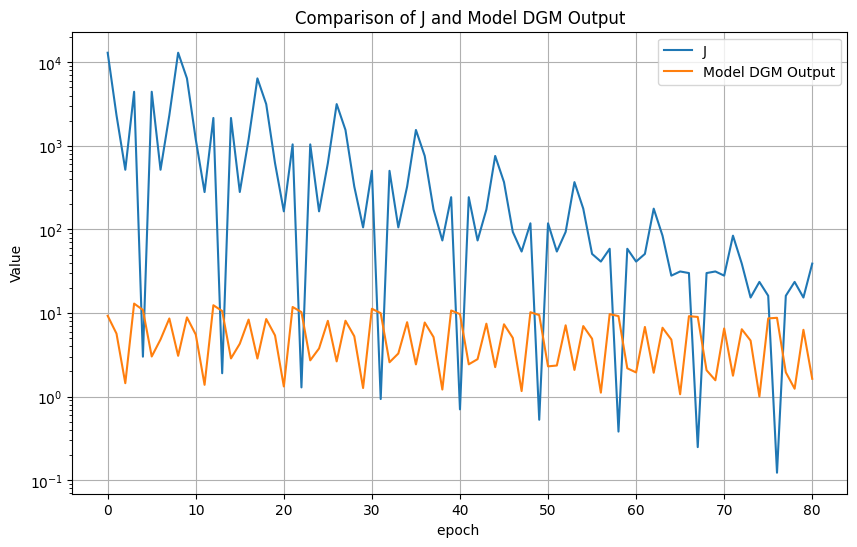

In [58]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(J[0].numpy(), label = 'J')
plt.plot(J_model.detach().numpy(), label='Model DGM Output')

plt.yscale('log')
plt.xlabel('epoch ')
plt.ylabel('Value')
plt.title('Comparison of J and Model DGM Output')
plt.legend()
plt.grid(True)
plt.show()